# Data Structure:
- Galaxies (group)
  - Attributes(group)
    - halo_ids (dataset)
    - mass (dataset)
    - ...
  - Particles (group)
    - DM (group)
      - ...
    - Stars (group)
      - Maps (group)
        - Mass (dataset)
        - Metal (dataset)
        - Age (dataset)
      - ...
    - Gas (group)
      - ...


In [1]:
import h5py
# Set the parameters
simulation = "IllustrisTNG" # Simulation name
particle_types = ["stars"] # Particle types
image_res = (64,64) # Image resolution
halo_ids= [15,20]

fields = {"Masses":False, 
          "GFM_Metallicity":False,
          "GFM_StellarFormationTime":True} # Fields to calculated images for and if they are mass weighted or not
plot_factor = 10 # Plot factor for the image: plot_factor*halfmassrad = image range

galaxy_parameters = ["mass","halo_id"] # Attributes of Galaxy Class to be saved for each galaxy (TODO: This atm only works for scalar parameters)
basePath = f"/export/data/ucakir/TNG100/TNG100-1/output/"

# Arguments passed to the galaxy class. Halo ID and particle type are overwritten in the loop.
kwargs = {"base_path":basePath,"halo_id":0,"particle_type": "stars", "snapshot":99}


# Open the HDF5 file in "w" mode to create a new file
with h5py.File("galaxy_data.hdf5", "w") as f:
    # Create the Galaxies group
    galaxies_group = f.create_group("Galaxies")
    
    # Create the datasets for the galaxy parameters
    for parameter in galaxy_parameters:
        galaxies_group.create_dataset(parameter, shape=(len(halo_ids),), maxshape=(None,))    
    
    particles_group = galaxies_group.create_group("Particles")
    # Create the Particle Types group
    for particle_type in particle_types:
        particle_type_group = particles_group.create_group(particle_type)
        
        # Create the Images group
        images_group = particle_type_group.create_group("Images")
        
        # Create the datasets for the images
        for field in fields:
            images_group.create_dataset(field, shape=(len(halo_ids), *image_res), maxshape=(None, None,None))
    

In [9]:
import tables
tables.file._open_files.close_all()

In [3]:
from galaxy import Galaxy
from tqdm import tqdm
# Open the HDF5 file in "append" mode
with h5py.File("galaxy_data.hdf5", "a") as f:

    # Loop through the galaxies
    for index, haloid in tqdm(enumerate(halo_ids)):
        # Create the galaxy object
        kwargs["halo_id"] = haloid
        
        g = Galaxy(simulation= simulation, **kwargs) 
        
        # Get the galaxy parameters
        for parameter in f["Galaxies"].keys():
            if parameter == "Particles":
                continue
            if hasattr(g,parameter):
                f["Galaxies"][parameter][index] = getattr(g,parameter)
            else: 
                raise ValueError(f"Galaxy class does not have the attribute {parameter}")
            
        # Get the particle data
        for particle_type in f["Galaxies"]["Particles"].keys():
            # Get the particle data
            for field in f["Galaxies"]["Particles"][particle_type]["Images"].keys():
                # Get the image
                image = g.get_image(field, plot_factor, image_res)
                f["Galaxies"]["Particles"][particle_type]["Images"][field][index] = image
        
        
        
        
        
        
        
        
        '''        
        star_mass_data_i = calculate_star_mass_data(i)
        star_metal_data_i = calculate_star_metal_data(i)
        star_age_data_i = calculate_star_age_data(i)

        # Append the data to the datasets
        mass_dataset.resize((i + 1,))
        mass_dataset[i] = mass_data_i

        stars_mass_dataset.resize((i + 1,))
        stars_mass_dataset[i] = star_mass_data_i

        stars_metal_dataset.resize((i + 1,))
        stars_metal_dataset[i] = star_metal_data_i

        stars_age_dataset.resize((i + 1,))
        stars_age_dataset[i] = star_age_data_i
        '''


0it [00:00, ?it/s]

No unit conversion for Field GFM_Metallicity. Return without changes.


1it [00:13, 13.90s/it]

No unit conversion for Field GFM_Metallicity. Return without changes.


2it [00:21, 10.68s/it]


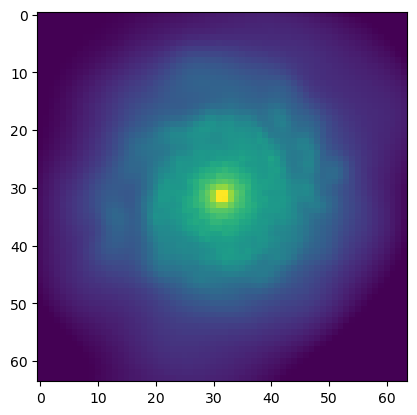

In [13]:
file = h5py.File("galaxy_data.hdf5", "r")

from matplotlib import pyplot as plt

plt.imshow(file["Galaxies/Particles/stars/Images/Masses"][1])










file.close()